**<h1>Problem Statement</h1>**

<li>Pneumonia kills more children than any other infectious disease, claiming the lives of over <b>800,000 children under five every year and around 2,200</b> every day.</li> 

<li>Globally, there are over <b>1,400cases of pneumonia per 100,000</b> children, and <b>1 case per 71 children</b> every year.</li>

<li>In South Asia 2,500 cases per 100,000 children were reported every year.</li>

<li>In West and Central Africa (1,620 cases per 100,000 children).</li>


Source : https://data.unicef.org/topic/child-health/pneumonia/

<li>Most children experience coughing and fast or difficult breathing due to a problem in the chest as a symptom.</li>

<li>Most of the symptoms of pneumonia shows the signs of respiratory infections.</li>

<li>These symptoms can be identified and detected by the radiologists by observing the CT-scans and X-rays images of the chest area.</li>

<li>Today, most of the medical researchs are supported by Deep learning algorithms to understand and interpret medical images.</li>


**<h1>Aims & Objectives</h1>**

<li><b>We have seen tremendous research going on in the medical imaging by utilizing available medical CT scan images and xray images.</b></li>

<li><b>At November 15, 2017, Stanford researchers have developed an algorithm that offers diagnoses based off chest X-ray images.</b></li>

<li><b>It can diagnose up to 14 types of medical conditions and is able to diagnose pneumonia better than expert radiologists working alone.</b></li>

<li><b>Thus, it is possible to use Deep Learning algorithms to detect the disease from images of Chest X-rays and CT scans.</b></li>

<li><b>Automated applications can be created to help support radiologists.</b></li>

<li><b>So,this project aims to detect pneumonia cases from the xray images.</b></li>

<li><b>This project will be an end to end solution where the user/radiologist will upload the chest x-ray image to the app and the app would return the predictions denoting whether the patient has pnumonia or not.</b></li>



**<h1>Data Availability</h1>**

**<h6>Data Source </h6>**
https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

<ul>
<li><b>Acknowledgements</b></li>
<ul>
<li>License: CC BY 4.0</li>
<li>Citation: http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5</li>
</ul>
</ul>

<li>The dataset is organized into 3 folders (train, test, val).</li>

<li>Each folder contains subfolders for each image category (Pneumonia/Normal).</li>

<li>There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).</li>

<li>Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou.</li>

<b>anterior-posterior : front-back</b>

<b>pediatric : children</b>

<li>A retrospective cohort study (also known as a historic study or longitudinal study) is a study where the participants already have a known disease or outcome. The study looks back into the past to try to determine why the participants have the disease or outcome and when they may have been exposed.</li>

<li>All chest X-ray imaging was performed as part of patients’ routine clinical care.</li>



<li>For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans.</li>

<li>The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system.</li>

<li>In order to account for any grading errors, the evaluation set was also checked by a third expert.</li>

**<h1>Implementation</h1>**

In [1]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 58 kB 4.1 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=33dcbdae111fc353f0ae89cdda501f25a3e7876b4641969b02f71d59acb5487c
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


**<h2>Importing necessary libraries</h2>**

In [2]:
import os

import cv2
import json
import random
import zipfile
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from PIL import Image
import plotly.express as px
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.utils import class_weight
from tensorflow.keras.models import Model
from google.colab.patches import cv2_imshow
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import InceptionV3
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.layers import Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 

warnings.filterwarnings("ignore")

**<h2>Downloading data from Kaggle using Api Key</h2>**

In [3]:
os.mkdir('/content/kaggle')

In [4]:
token = {"username" : "prabhatale", "key" : "847b0547dfa44b477a7807fb0e9e9de8"}
with open('/content/kaggle/kaggle.json', 'w') as file:
  json.dump(token, file)

In [8]:
!cp /content/kaggle/kaggle.json ~/.kaggle/kaggle.json

In [9]:
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [10]:
!chmod 600 /root/.kaggle/kaggle.json

In [11]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia -p /content

 99% 2.28G/2.29G [00:29<00:00, 40.6MB/s]
100% 2.29G/2.29G [00:29<00:00, 82.4MB/s]


**<h2>Extracting zip files</h2>**

In [12]:
archive = zipfile.ZipFile('/content/chest-xray-pneumonia.zip')
archive.extractall('/content')

In [13]:
xray_result = ['NORMAL', 'PNEUMONIA']
data_dir = '/content/chest_xray/chest_xray'
train_dir = "/content/chest_xray/chest_xray/train"   
valid_dir = "/content/chest_xray/chest_xray/val"
test_dir = "/content/chest_xray/chest_xray/test"

**<h2>Exploratory Data Analysis</h2>**

In [14]:
!rm -rf "/content/chest_xray/chest_xray/.DS_Store"
!rm -rf "/content/chest_xray/chest_xray/train/.DS_Store"
!rm -rf "/content/chest_xray/chest_xray/test/.DS_Store"
!rm -rf "/content/chest_xray/chest_xray/val/.DS_Store"
!rm -rf "/content/chest_xray/chest_xray/train/NORMAL/.DS_Store"
!rm -rf "/content/chest_xray/chest_xray/test/NORMAL/.DS_Store"
!rm -rf "/content/chest_xray/chest_xray/val/NORMAL/.DS_Store"
!rm -rf "/content/chest_xray/chest_xray/train/PNEUMONIA/.DS_Store"
!rm -rf "/content/chest_xray/chest_xray/test/PNEUMONIA/.DS_Store"
!rm -rf "/content/chest_xray/chest_xray/val/PNEUMONIA/.DS_Store"

<li><b>The dataset contains a hidden folder named '.DS_Store' which create obstacles while doing analysis.</b></li>

<li><b>So, I decide to remove these hidden folders to continue my analysis.</b></li>

In [15]:
def check_counts(data_dir):
  
  frequency_counts = {}
  for split_type in os.listdir(data_dir):
    path_to_split_type = os.path.join(data_dir, split_type)
    for category in os.listdir(path_to_split_type):
      counts_key = split_type + '_' + category + '_' + 'counts'
      frequency_counts[counts_key] = len(os.listdir(os.path.join(path_to_split_type, category)))
  for key in list(frequency_counts.keys()):
    split_key = key.split('_')[0]
    counts_key = split_key + '_' + 'counts'
    if counts_key not in frequency_counts:
      frequency_counts[counts_key] = frequency_counts[key]
    else:
      frequency_counts[counts_key] += frequency_counts[key]

  return frequency_counts


In [16]:
frequency_counts = check_counts(data_dir)
print(frequency_counts)

{'val_NORMAL_counts': 8, 'val_PNEUMONIA_counts': 8, 'test_NORMAL_counts': 234, 'test_PNEUMONIA_counts': 390, 'train_NORMAL_counts': 1341, 'train_PNEUMONIA_counts': 3875, 'val_counts': 16, 'test_counts': 624, 'train_counts': 5216}


**<h4>Train Test Valid Split Ratio</h4>**

In [17]:
def create_bargraph(dict_count, labels):

  fig = plt.figure(figsize = (6, 6))
  counts = [dict_count[key] for key in dict_count if key in labels]
  axis = sns.barplot(labels, counts)
  total = sum(counts)
  plt.title('Train Test Valid Split Ratio')
  plt.xlabel('Split Types')
  plt.ylabel('Frequency Counts')
  for plot in axis.patches:
    height = plot.get_height()
    height_percentage = "{:.1f}%".format((100 * height)/ total)
    axis.text(plot.get_x()+plot.get_width()/2., height + 5, height_percentage ,ha="center")
  plt.show()

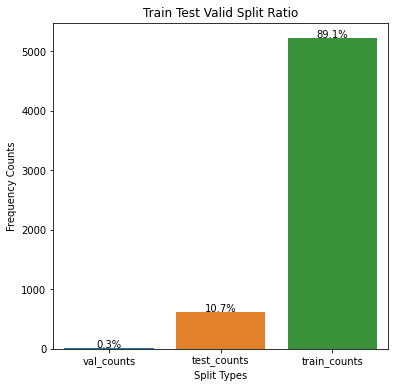

In [18]:
labels = list(frequency_counts.keys())[-3:]
create_bargraph(frequency_counts, labels)

<li><b>About 89.0% of the total dataset is comprised of training datasets.</b></li>

<li><b>About 10.6% of the total dataset is comprised of testing datasets.</b></li>

<li><b>Only about 0.3% of the total datasets is comprised of validation datasets.</b></li>



In [19]:
keys = list(frequency_counts.keys())[:-3]
split_count_df = pd.DataFrame({'split_type' : [key.split('_')[0] for key in keys],
                   'xrays' : [key.split('_')[1:-1][0] + '_' + key.split('_')[1:-1][1] if len(key.split('_')[1:-1]) > 1 else key.split('_')[1:-1][0] for key in keys],
                   'counts' : [frequency_counts[key] for key in keys]})
split_count_df

,split_type,xrays,counts
0,val,NORMAL,8
1,val,PNEUMONIA,8
2,test,NORMAL,234
3,test,PNEUMONIA,390
4,train,NORMAL,1341
5,train,PNEUMONIA,3875


In [20]:
fig = px.bar(split_count_df, x="split_type", y="counts", color="xrays", title="Distribution of pneumonia patients from chest xray images")
fig.show()

<li><b>From this figure, we can get a visual 
interpretation of the distribution of pneumonia cases in different splits of the datasets</b></li>

<li><b>There are 3875 patients who have pneumonia out of 5216 patients in the training datasets which is around 74.29% of total training datasets.</b></li>

<li><b>There are 1341 patients who donot suffer from pneumonia in the training datasets which is around 25.71% of total training datasets.</b></li>

<li><b>There are 390 xray images where pneumonia is detected and 234 images where no pneumonia is detected in the testing datasets.</b></li>

<li><b>In testing datasets, the ratio of patients suffering from pneumonia to those who are normal is 62.5% : 27.5%.</b></li>

<li><b>There are 8 xray images of pneumonia patients and 8 xray images of normal patients in the validation datasets.</b></li>


**<h4>Pie-chart</h4>**

In [82]:
fig = px.pie(split_count_df, values='counts', names='xrays', title = 'Distribution of each class in the overall datasets')
fig.show()

<li><b>From the given piechart, we can see that there is class imbalance problem in the dataset.</li>

<li>About 73% of xray images belongs to pneumonia patients and remaining 27% of data is represented by normal xray images.</b></li> 

<li><b>There are 4273 xray images of pneumonia patients and 1583 xray images of nomral patients in the overall datasets.</b></li>

**<h4>Insights From Quick Glance</h4>**

<li><b>There are a total of 5856 image datasets</b></li>
<li><b>The overall image datasets is categorized into two main classes : 'NORMAL' and 'PNEUMONIA'.</b></li>
<li><b>The overall datasets is divided into three different splits : training, testing and validation.</b></li>
<li><b>The train : test : valid split ratio of the dataset is 89.1 : 10.7 : 0.3.</b></li>
<li><b>There is class imbalance problem in the dataset.</b></li>
<li><b>About 73% of data is represented by pneumonia patients and remaining 27% cases were covered by normal patients.</b></li>

In [22]:
def get_images(data_dir, number_of_samples, xray_type):
  
  image_path = []
  for category in os.listdir(data_dir):
    if category == xray_type:
      path_to_category = os.path.join(data_dir, category)
      counter = 1
      for img in os.listdir(path_to_category):
        if img.endswith('.jpg') or img.endswith('.jpeg') or img.endswith('.png'):
          if counter > number_of_samples:
            break
          else:
            image_path.append(os.path.join(path_to_category, img))
            counter += 1
  return image_path

In [23]:
def visualize_dataset(image_path, rows, cols):
  
  fig = plt.figure(figsize=(12,12))
  for i in range(1,rows * cols + 1):
    fig.add_subplot(rows,cols,i)
    img_array = cv2.imread(image_path[i-1])
    fig.subplots_adjust(hspace=1)
    plt.imshow(cv2.cvtColor(img_array,cv2.COLOR_BGR2RGB))
    plt.xlabel(image_path[i-1].split('/')[-2])
  plt.show()

**<h4>Data Visualization</h4>**

**<h6>Visualizing each class separately</h6>**

**<h6>Normal</h6>**

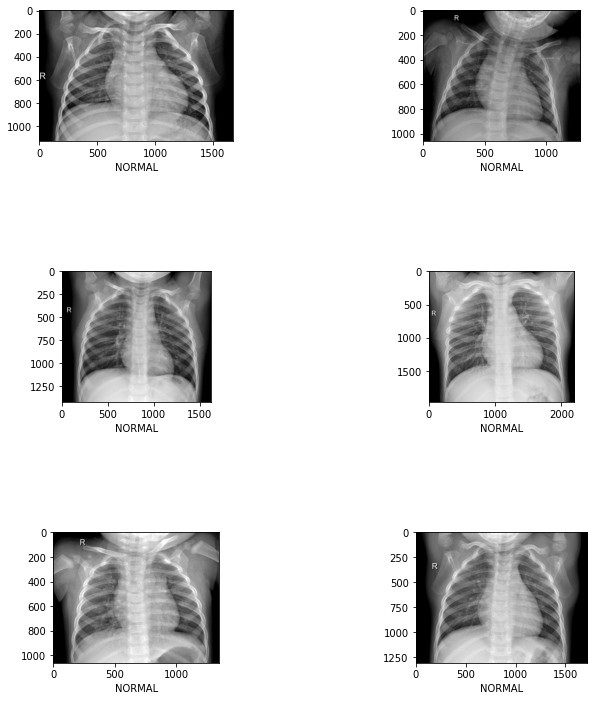

In [24]:
normal_image_path = get_images(data_dir = train_dir, number_of_samples = 6, xray_type = 'NORMAL')
visualize_dataset(image_path = normal_image_path, rows=3, cols=2)

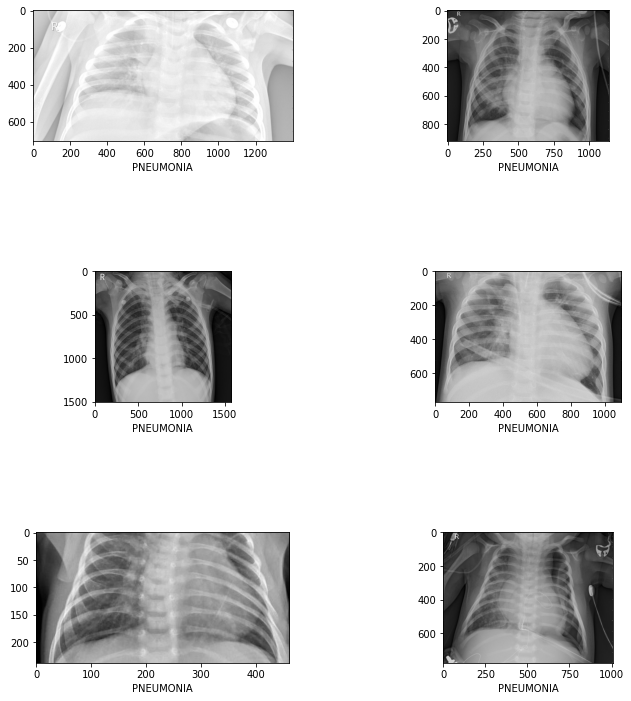

In [25]:
penumonia_image_path = get_images(data_dir = train_dir, number_of_samples = 6, xray_type = 'PNEUMONIA')
visualize_dataset(image_path = penumonia_image_path, rows=3, cols=2)

**<h4>Resizing an Image to optimize computation during training.</h4>**

In [26]:
def resize_image(data_dir):

  for category in os.listdir(data_dir):
    path_to_category = os.path.join(data_dir, category)
    for img in tqdm(os.listdir(path_to_category)):
      img_arr = Image.open(os.path.join(path_to_category, img))
      resized_img_arr = img_arr.resize((400, 400))
      resized_img_arr.save(os.path.join(path_to_category, img))

In [27]:
resize_image(data_dir = train_dir)
resize_image(data_dir = test_dir)
resize_image(data_dir = valid_dir)

100%|██████████| 8/8 [00:00<00:00, 81.24it/s]


<li><b>The whole dataset is resized into (400, 400) image size.</b></li>

In [28]:
for xray in os.listdir(train_dir):
  path = os.path.join(train_dir, xray)
  print("There are {} images of {}".format(len(os.listdir(path)),xray))

for xray in os.listdir(test_dir):
  path = os.path.join(test_dir,xray)
  print("There are {} images of {}".format(len(os.listdir(path)),xray))

for xray in os.listdir(valid_dir):
  path = os.path.join(valid_dir,xray)
  print("There are {} images of {}".format(len(os.listdir(path)),xray))

There are 1341 images of NORMAL
There are 3875 images of PNEUMONIA
There are 234 images of NORMAL
There are 390 images of PNEUMONIA
There are 8 images of NORMAL
There are 8 images of PNEUMONIA


**<h4>Modelling</h4>**

In [44]:
train_datagen = ImageDataGenerator(rescale = 1/255.0)

valid_datagen = ImageDataGenerator(rescale=1/255.0)

In [45]:
train_generator = train_datagen.flow_from_directory(directory=train_dir, target_size=(400,400),
                                                    color_mode='rgb', class_mode='binary',
                                                    batch_size = 25, shuffle=True)

valid_generator = valid_datagen.flow_from_directory(directory=test_dir, target_size=(400,400), color_mode='rgb',
                                                    class_mode='binary', batch_size = 25, shuffle=True)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


**<h4>Weighted binary Crossentropy for handling class imbalance problem</h4>**

In [46]:
counter = Counter(train_generator.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}  
print(class_weights) 

{0: 2.889634601043997, 1: 1.0}


**<h2>Pretrained Model Selection</h2>**

In [47]:
inceptionnet = InceptionV3(weights='imagenet',include_top=False,input_shape=(400,400,3))

In [48]:
# for layer in inceptionnet.layers:
#   layer.trainable = False

# adding regularization
# regularizer = tensorflow.keras.regularizers.l2(penalty)

# for layer in base_model.layers:
#     for attr in ['kernel_regularizer']:
#         if hasattr(layer, attr):
#           setattr(layer, attr, regularizer)

**<h4>Batch Normalization</h4>**

<li><b>Batch normalization is a technique for training very deep neural networks that standardizes the inputs to a layer for each mini-batch.</b></li>


<li><b>Batch normalisation normalises a layer input by subtracting the mini-batch mean and dividing it by the mini-batch standard deviation.</b></li>

<li><b>This has the effect of stabilizing the learning process and dramatically reducing the number of training epochs required to train deep networks.</b></li>


In [49]:
for layer in inceptionnet.layers:
  layer.trainable = True if isinstance(layer, BatchNormalization) else False

In [50]:
output = Flatten() (inceptionnet.output)
output = Dropout(0.7) (output)
prediction = Dense(1, activation='sigmoid') (output)

In [51]:
model = Model(inputs = inceptionnet.input,outputs = prediction)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 400, 400, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 199, 199, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 199, 199, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 199, 199, 32) 0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

**<h4>Compiling the model performance</h4>**

In [52]:
model.compile(
  loss='binary_crossentropy',
  optimizer=Adam(
    learning_rate=0.00001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07
),
  metrics=['accuracy']
)

In [38]:
import os
os.mkdir('/content/model_weights/')

In [39]:
model_checkpoint = ModelCheckpoint('./model_weights/pneumonia_detection_model_{epoch:02d}-{val_accuracy:.6f}.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True, save_weights_only=True)

In [56]:
def scheduler(epoch, lr):
  if epoch < 1:
    return lr
  else:
    return lr / 10

In [57]:
lrate = LearningRateScheduler(scheduler,verbose=1)

In [58]:
model_json = model.to_json()
with open("pneumonia_detection_inception_model.json", "w") as json_file:
    json_file.write(model_json)

In [59]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // 25,
    validation_data = valid_generator, 
    validation_steps = valid_generator.samples // 25,
    epochs = 10,
    callbacks=[model_checkpoint, lrate],
    class_weight = class_weights)

Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
208/208 [==============================] - 100s 458ms/step - loss: 0.6018 - accuracy: 0.8251 - val_loss: 0.4236 - val_accuracy: 0.7867

Epoch 00001: val_loss improved from inf to 0.42364, saving model to ./model_weights/pneumonia_detection_model_01-0.786667.h5
Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
208/208 [==============================] - 95s 459ms/step - loss: 0.3696 - accuracy: 0.8962 - val_loss: 0.4033 - val_accuracy: 0.8117

Epoch 00002: val_loss improved from 0.42364 to 0.40326, saving model to ./model_weights/pneumonia_detection_model_02-0.811667.h5
Epoch 3/10

Epoch 00003: LearningRateScheduler setting learning rate to 9.999999747378752e-07.
208/208 [==============================] - 96s 459ms/step - loss: 0.3122 - accuracy: 0.9083 - val_loss: 0.3617 - val_accuracy: 0.8450

Epoch 00003: val_loss improved from 0.40326 to 0.36172,

Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7f7483c82b90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


Epoch 4/10

Epoch 00004: LearningRateScheduler setting learning rate to 9.999999974752428e-08.
208/208 [==============================] - 96s 460ms/step - loss: 0.3117 - accuracy: 0.9112 - val_loss: 0.3786 - val_accuracy: 0.8500

Epoch 00004: val_loss did not improve from 0.36172
Epoch 5/10

Epoch 00005: LearningRateScheduler setting learning rate to 1.0000000116860974e-08.
208/208 [==============================] - 96s 460ms/step - loss: 0.3028 - accuracy: 0.9168 - val_loss: 0.3817 - val_accuracy: 0.8550

Epoch 00005: val_loss did not improve from 0.36172
Epoch 6/10

Epoch 00006: LearningRateScheduler setting learning rate to 9.99999993922529e-10.
208/208 [==============================] - 95s 459ms/step - loss: 0.2990 - accuracy: 0.9206 - val_loss: 0.3891 - val_accuracy: 0.8500

Epoch 00006: val_loss did not improve from 0.36172
Epoch 7/10

Epoch 00007: LearningRateScheduler setting learning rate to 9.999999717180686e-11.
208/208 [==============================] - 96s 459ms/step - lo

**<h4>Training Vs Validation Accuracy</h4>**

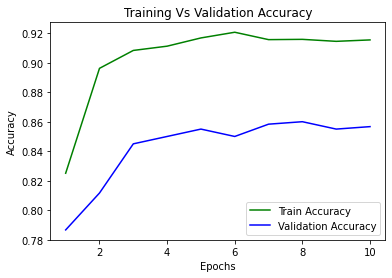

In [77]:
train_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
epochs = range(1,11)
plt.plot(epochs,train_accuracy,'g',label='Train Accuracy')
plt.plot(epochs,validation_accuracy,'b',label='Validation Accuracy')
plt.title('Training Vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('training_vs_validation_accuracy_pneumonia_detection.jpg')
plt.show()

**<h4>Training Vs Validation Loss</h4>**

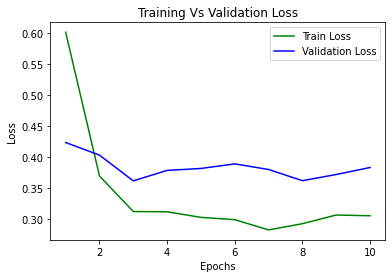

In [78]:
train_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, 11)
plt.plot(epochs,train_loss,'g',label='Train Loss')
plt.plot(epochs,validation_loss,'b',label='Validation Loss')
plt.title('Training Vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('training_vs_validation_loss_pneumonia_detection.jpg')
plt.show()

In [65]:
def check_xray(data_dir, category_type):
  predictor = {}
  path = os.path.join(data_dir, category_type)
  for img in os.listdir(path):
    img = image.load_img(os.path.join(path, img), target_size=(400, 400))
    img_arr = image.img_to_array(img)
    expand_img_arr = np.expand_dims(img_arr, axis=0)
    normalized_img_arr = expand_img_arr / 255.0
    prediction = model.predict(normalized_img_arr)
    if prediction > 0.5:
      prediction_class = 1
    else:
      prediction_class = 0
    result = xray_result[prediction_class]
    if result not in predictor:
      predictor[result] = 1
    else:
      predictor[result] += 1
  return predictor

In [66]:
check_xray(data_dir = test_dir, category_type = 'NORMAL')

{'NORMAL': 162, 'PNEUMONIA': 72}

<li><b>When we check how our model performance in the validation dataset, we found that out of 234 normal patients, the model predicts 162 patients as NORMAL whereas it misclassified 72 normal patients as pneumonia patients</b></li>

In [67]:
check_xray(data_dir = test_dir, category_type = 'PNEUMONIA')

{'NORMAL': 19, 'PNEUMONIA': 371}

<li><b>Out of 390 pneumonia patient's xray images, the model predicted 371 patients as pneumonia patients whereas it misclassified 19 patients who have a pneumonia as normal patients in the validation datasets.</b></li>

In [68]:
check_xray(data_dir = valid_dir, category_type = 'NORMAL')

{'NORMAL': 5, 'PNEUMONIA': 3}

<li><b>When we check how our model performance against the new unseen test dataset, we found that out of 8 normal patients, the model predicts 5 patients as NORMAL whereas it misclassified 3 normal patients as pneumonia patients.</b></li>

In [69]:
check_xray(data_dir = valid_dir, category_type = 'PNEUMONIA')

{'PNEUMONIA': 8}

<li><b>Out of 8 pneumonia patient's xray images, the model predicted all 8 patients as pneumonia patients in the new unseen test datasets.</b></li>

In [73]:
def calculate_predictions(data_dir):

  truth_values = []
  predicted_values = []
  for category in os.listdir(data_dir):
    path = os.path.join(data_dir, category)
    for img in os.listdir(path):
      img = image.load_img(os.path.join(path, img), target_size=(400, 400))
      img_arr = image.img_to_array(img)
      expand_img_arr = np.expand_dims(img_arr, axis=0)
      normalized_img_arr = expand_img_arr / 255.0
      prediction = model.predict(normalized_img_arr)
      if prediction > 0.5:
        prediction_class = 1
        truth_values.append(xray_result.index(category))
        predicted_values.append(prediction_class)
      else:
        prediction_class = 0
        truth_values.append(xray_result.index(category))
        predicted_values.append(prediction_class)
  results = {'real' : truth_values, 'predicted' : predicted_values}
  return results

In [74]:
results = calculate_predictions(data_dir = test_dir)

In [75]:
truth_value, predicted_value = results['real'], results['predicted']
print(classification_report(truth_value, predicted_value, target_names = xray_result, digits=4))

              precision    recall  f1-score   support

      NORMAL     0.8950    0.6923    0.7807       234
   PNEUMONIA     0.8375    0.9513    0.8908       390

    accuracy                         0.8542       624
   macro avg     0.8662    0.8218    0.8357       624
weighted avg     0.8591    0.8542    0.8495       624



<li><b>Precision is a metric that quantifies the number of correct positive predictions made. Precision, therefore, calculates the accuracy for the minority class. It is calculated as the ratio of correctly predicted positive examples divided by the total number of positive examples that were predicted.</b></li>

<li><b>Recall is a metric that quantifies the number of correct positive predictions made out of all positive predictions that could have been made. Unlike precision that only comments on the correct positive predictions out of all positive predictions, recall provides an indication of missed positive predictions.</b></li>

<li><b>The F-score is a way of combining the precision and recall of the model, and it is defined as the harmonic mean of the model's precision and recall.</b></li>

In [91]:
confusion_matrix(truth_value, predicted_value)

array([[162,  72],
       [ 19, 371]])

<li><b>In Conclusion, Out of Out of 390 pneumonia patient's xray images, the model predicted 371 patients as pneumonia patients whereas it misclassified 19 patients who have a pneumonia as normal patients in the validation datasets.</b></li>

<li><b>Out of 234 normal patients, the model predicts, 162 patients as normal whereas the model misclassified 72 patients as pneumonia patients.</b></li>